# 画像のクラス分類１

## 問題設定
フィルタの概念が理解できたところで、犬や猫をうまく見抜くフィルタの値はいくらでしょうか？
この問題が画像処理には常に付きまといます。

そこで、Convolutional Neural Network ではこのフィルタの値をパラメータとして最適化することで、どのようなフィルタを設計すればよいのかわからなかった問題設定に対しても機械学習を適用可能にしているというわけです。

それでは、サンプルとして非常に有名である`MNIST`という 0～9 までの 10 種類の手書き数字の認識を行ってみましょう。


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Pythonの挙動を整えるライブラリのインポート
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow と tf.keras のインポート
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.0.0


解析環境の確認をしましょう。GPU が使える状態になっていますね。

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10324610145585885452
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8145449667066141968
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14102957516281603353
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 209125376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 726149974269478232
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: bfde:00:00.0, compute capability: 3.7"
]


## データセットの読み込み

In [4]:
from tensorflow.keras.datasets import mnist

In [5]:
train, test = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


サンプルとしてはデータセットの準備が不要で、CNN のモデル構築の練習になるのですが、最終的に自作のデータセットに対して適用していくことを考えると、どのようなデータセットの形式であれば良いかわからないのは非常にまずいことです。
そのため、動くデータセットの形式をまず確認しておきましょう。

In [6]:
type(train)

tuple

In [7]:
len(train)

2

In [8]:
train[0]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [9]:
train[1]

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [10]:
train[1].shape

(60000,)

In [11]:
test[1].shape

(10000,)

この Keras のデータセットは`（画像、ラベル）`のようにタプル形式で格納されています。

- train[0]: 60000サンプルの画像が格納
- train[0][0]: １サンプル目の画像（uint8）
- train[1]: 60000サンプルのラベルが格納
- train[1][1]: １サンプル目のラベル（uint8）

サイズ等を確認しておきましょう。

In [12]:
type(train[0])

numpy.ndarray

In [13]:
train[0][0].shape  # 後述

(28, 28)

In [14]:
train[0].dtype

dtype('uint8')

In [15]:
type(train[1])

numpy.ndarray

In [16]:
train[1][1].shape

()

In [17]:
train[1].dtype

dtype('uint8')

ここでわかることとして、画像が( height, width, channel )の順ではなく、( height, width )の順に格納されていることです。

CNN で扱う際には、( height, width, channel )順に変換しておかないといけないため、覚えておきましょう。

試しに １ 枚目をプロットしてみましょう。

In [18]:
img = train[0][0]

In [19]:
img.shape

(28, 28)

すでにグレースケールで保存されているのでそのまま表示しましょう。

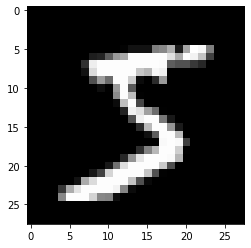

In [20]:
plt.gray()
plt.imshow(img)

こちらのように手書き文字の ５ がデータとして格納されていることがわかりました。
データセットの形式を確認しながら試行錯誤する癖をつけておくようにしてください。

では、画像のサイズを( height, width )から( height, width, channel )へと変換します。また画像の値を正規化しておきましょう。

In [21]:
train_x = train[0].reshape(60000, 28, 28, 1) / 255 # 正規化
test_x = test[0].reshape(10000, 28, 28, 1) / 255 # 正規化

In [22]:
train_t = train[1]
test_t = test[1]

In [23]:
train_x[0].shape

(28, 28, 1)

## CNN モデルの定義

それでは、画像処理で定番となっている Convolutional Neural Network （ CNN ）の実装を行っていきましょう。

まずは、Keras でよく使用するモジュールを読み込んでおきましょう。

In [24]:
import os
import random

def reset_seed(seed=0):
    
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed) #　random関数のシードを固定
    np.random.seed(seed) #numpyのシードを固定
    tf.random.set_seed(seed) #tensorflowのシードを固定

In [25]:
from tensorflow.keras import models,layers

# シードの固定
reset_seed(0)

# モデルのインスタンス化
model = models.Sequential()

# モデルの構築
model.add(layers.Conv2D(3, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten()) # 畳み込み層から全結合層へつなぐ時は必ず入れる
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# optimizerの設定
optimizer = keras.optimizers.Adam(lr=0.01)

# モデルのコンパイル
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [26]:
# 学習の詳細設定
batch_size = 4096
epochs = 30

# 学習の実行
history = model.fit(train_x, train_t, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(test_x, test_t))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 2s 39us/sample - loss: 0.9005 - accuracy: 0.7333 - val_loss: 0.3816 - val_accuracy: 0.8949
Epoch 2/30
60000/60000 [==============================] - 0s 7us/sample - loss: 0.3285 - accuracy: 0.9054 - val_loss: 0.2628 - val_accuracy: 0.9210
Epoch 3/30
60000/60000 [==============================] - 0s 7us/sample - loss: 0.2375 - accuracy: 0.9306 - val_loss: 0.2019 - val_accuracy: 0.9367
Epoch 4/30
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1882 - accuracy: 0.9446 - val_loss: 0.1668 - val_accuracy: 0.9463
Epoch 5/30
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1561 - accuracy: 0.9531 - val_loss: 0.1437 - val_accuracy: 0.9544
Epoch 6/30
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1334 - accuracy: 0.9605 - val_loss: 0.1290 - val_accuracy: 0.9590
Epoch 7/30
60000/60000 [==============================] - 0s 

検証データに関する損失関数の値は0.1  
精度は 97% 程度ありますね。

## 学習済みモデルを保存

学習が終わると、学習済みモデルが得られます。前回は HDF 5形式のファイルにモデル全体（構造＋重み＋最適化関数の状態）を保存しました。今回はそれらを個別に保存します。これによって転移学習などに用いるパラメータを簡単に扱えます。

### モデルのセーブ

今回は学習済みモデルを以下の２つ  
* アーキテクチャ（構造）
* パラメータ（重み）  

に分割して保存します。

#### モデルアーキテクチャの保存

In [27]:
# JSON形式で保存
json_string = model.to_json()
# ファイルを書き出して保存
with open('my_model.json','w')as f:
  f.write(json_string)

#### モデルパラメータ（重み）の保存

In [28]:
# HDF5形式のファイル'my_model.h5'を作成し保存
model.save_weights('my_model.h5')

一度作成したモデルを削除します。

In [29]:
#モデルの削除
del model

## 学習済みモデルによる推論
訓練に使用したデータですが、実際にうまく推論できるかを確認しましょう。

では、学習済みモデルのロードから始めていきましょう。

### 学習済みモデルのロード

まずは学習済みモデルのアーキテクチャを読み込みます。そして、そのモデルに対してパラメータを読み込みます。

#### モデルアーキテクチャの読み込み

In [30]:
from tensorflow.keras.models import model_from_json

# JSONからのモデル再構築
model = model_from_json(json_string)

#### モデルパラメータ（重み）の読み込み
上記で読み込んだモデルアーキテクチャに重みの読み込みを行います。

In [31]:
# パラメータの読み込み
model.load_weights('my_model.h5')

### 推論

In [32]:
x = test[0][0]
t = test[1][0]

In [33]:
t

7

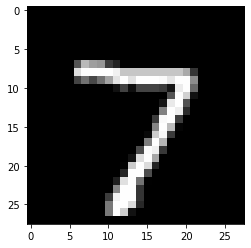

In [34]:
plt.imshow(x)

In [35]:
x = np.array([test_x[0]])

In [36]:
y = model.predict(x)

予測値`y`の値を確認してわかる通り、各クラスに属する値の回帰であるため、まだ分類の結果とは言えません。

In [37]:
y

array([[3.3168802e-12, 9.2197139e-09, 1.8594511e-07, 7.5112609e-07,
        9.3587193e-14, 2.4308677e-13, 1.4251452e-15, 9.9999893e-01,
        7.5916684e-10, 7.1296938e-08]], dtype=float32)

In [38]:
np.sum(y)

0.99999994

`np.sum()`で総和を取ると1になっていることが確認できます。

最大の値のインデックス番号は `np.argmax()`で取得できます。

In [39]:
np.argmax(y)

7

要素番号が７と推測されており、教師データの７と一致していて、正しく分類ができていますね。誤差が0ではないので正しく分類できていないケースもあります。

In [40]:
x = test[0][33]
t = test[1][33]
t

4

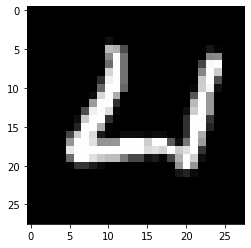

In [41]:
plt.imshow(x)

In [42]:
x = np.array([test_x[33]])
y = model.predict(x)
np.argmax(y)

4

## 演習課題

学習済みモデルで得られたフィルタの値を取得し、各画像に対して畳み込み（Convolution）を実行し、数字をうまく分類できるようなフィルタはどのような画像になっているか確かめてみましょう。

ヒント：  
今回のモデルのパラメータは下記で取得できます。

```python
W = model.layers[0].get_weights()[0]
```